<a href="https://colab.research.google.com/github/Larraguibel/DNN_neuroscience/blob/main/blurring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importaciones

In [ ]:
cuda = True
train_batch_size = 32
test_batch_size = 124
best_loss = float("inf")
best_epoch = -1
dataset_path = './cifar10'
gsync_save = True

In [ ]:
from torchvision import transforms, datasets
import torch
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
try:
    import torch
except ModuleNotFoundError:
    from os import path
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

    accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.1-{platform}-linux_x86_64.whl
    import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


try:
    import torchvision
except ModuleNotFoundError:
    !pip install -q torchvision

from torchvision import datasets, transforms


if gsync_save:
    try:
        import utils
    except ModuleNotFoundError:
        !wget https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/HEAD/utils.py
        import utils

    gsync = utils.GDriveSync()


try:
    from allconv import AllConvNet
except ModuleNotFoundError:
    !wget https://github.com/StefOe/all-conv-pytorch/raw/HEAD/allconv.py
    from allconv import AllConvNet

--2023-12-07 17:19:55--  https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/HEAD/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4519 (4.4K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   4.41K  --.-KB/s    in 0s      

2023-12-07 17:19:55 (70.2 MB/s) - ‘utils.py’ saved [4519/4519]

--2023-12-07 17:20:25--  https://github.com/StefOe/all-conv-pytorch/raw/HEAD/allconv.py
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/StefOe/all-conv-pytorch/8545bb3ff7ac4410e52d8db930f0485074073ea9/allconv.py [following]
--2023-12-07 17:20:25--  https://raw.

## 2. Transformacion y carga de datos

In [ ]:
# Semilla para estandarizar resultados
torch.manual_seed(2320)

cuda = cuda and torch.cuda.is_available()

trainset = datasets.CIFAR10(root=dataset_path, train=True, download=True)
train_mean = trainset.data.mean(axis=(0, 1, 2)) / 255
train_std = trainset.data.std(axis=(0, 1, 2)) / 255


# Data normal (32x32)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])


#  transformaciones a 8x8 y de vuelta a 32x32 por bilineal

transform_train8x8 = transforms.Compose([
    transforms.Resize((8,8)),
    transforms.Resize((32,32)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])


100%|██████████| 170498071/170498071 [00:01<00:00, 92662539.74it/s] 


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10


In [ ]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

# Data normal

train_loader = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train),
    batch_size=train_batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=dataset_path, train=False, download=True,
    transform=transform_test),
    batch_size=test_batch_size, shuffle=True, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Data de entrenamiento blurreada

train_loader_blur = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train8x8),
    batch_size=train_batch_size, shuffle=True, **kwargs)


Files already downloaded and verified


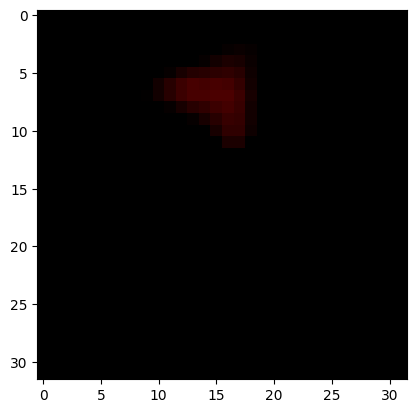

In [ ]:
for batch_data, batch_labels in train_loader_blur:
    first_image = batch_data[0].permute(1, 2, 0).numpy()
    plt.imshow(first_image)
    plt.show()
    break

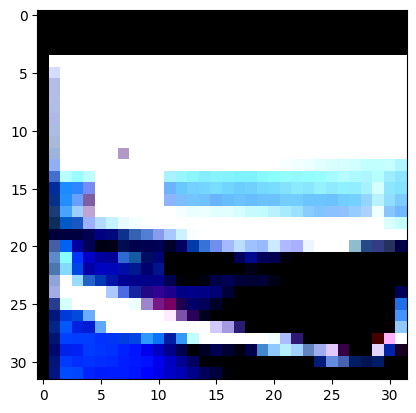

In [ ]:
for batch_data, batch_labels in train_loader:
    first_image = batch_data[0].permute(1, 2, 0).numpy()
    plt.imshow(first_image)
    plt.show()
    break

## 3. Entrenamiento

In [ ]:
model = AllConvNet(3)
if cuda:
    model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[200, 250, 300], gamma=0.1)

In [ ]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))


def blur_train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader_blur):
        if cuda:
            data, target = data.cuda(), target.cuda() # Pasar la data a la GPU
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad() # Seteo en 0 los valores de los gradientes
        output = model(data) # Hago forward
        loss = criterion(output, target) # Se calcula la CrossEntropyLoss
        loss.backward()
        optimizer.step() # Actualización de los parámetros

        if batch_idx % 100 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))


def test(epoch, best_loss, best_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        output = model(data)
        # sum up batch loss
        test_loss += criterion(output, target).item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
        acc = 100*correct/len(test_loader.dataset)


    test_loss /= len(test_loader.dataset)
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {} ({:.0f}%)\n'.format(
            test_loss, acc, 100. * correct /
            len(test_loader.dataset)))

    if test_loss < best_loss:
        best_epoch = epoch
        best_loss = test_loss
        torch.save(model, "best.pt")
        if gsync_save:
            gsync.update_file_to_folder("best.pt")
    return best_loss, best_epoch, acc

Esta primera version del codigo,  entrena:

*   normalmente para `normal_init` epocas
*   con blur para `blur_epochs` epocas
*   normalmente para otras `after_blur` epocas.

In [ ]:
def begin_model_easy(normal_init: int, blur_epochs: int, after_blur: int, model=None):
  best_loss = float("inf")
  best_epoch = -1

  if model is None:
    model = AllConvNet(3)

    if cuda:
        model.cuda()

  if normal_init<0 or blur_epochs<0 or after_blur<0:
    print('ERROR: parámetros inconsistentes')
  else:

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[200, 250, 300], gamma=0.1)

    if normal_init == 0:

      print(f''' {'*'*30}
      Blurred image Training begin
      {'*'*30}
      ''')

      for epoch in range(blur_epochs):
        scheduler.step()
        blur_train(epoch)
        best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch)

      print(f''' {'*'*30}
      Blurred image Training End. Training with normal images
      {'*'*30}
      ''')

      for epoch in range(blur_epochs, blur_epochs + after_blur):
        scheduler.step()
        train(epoch)
        best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch)


    elif normal_init != 0:

      print(f''' {'*'*30}
      Normal training begin
      {'*'*30}
      ''')
      for epoch in range(normal_init):
        scheduler.step()
        train(epoch)
        best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch)

      print(f''' {'*'*30}
      Blurred image Training begin
      {'*'*30}
      ''')

      for epoch in range(normal_init, normal_init + blur_epochs):
        scheduler.step()
        blur_train(epoch)
        best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch)

      print(f''' {'*'*30}
      Blurred image Training End. Training with normal images
      {'*'*30}
      ''')

      for epoch in range(normal_init+blur_epochs, normal_init+blur_epochs+after_blur):
        scheduler.step()
        train(epoch)
        best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch)

  print(f'''
  *********************
  final accuracy: {acc}
  *********************
  ''')

  return acc

# Experimento 1 de Achille et al.

Vamos a entrenar con blur por $t_0$ epocas, con $t_0\in \{0, 20, 40, ... , 140\}$ y sucesivamente entrenamos por $160$ epocas sin blur.

Para ahorrar calculos,
* primero entrenamos modelo con blur por $140$ epocas y con un checkpoint cada $20$ epocas,
* sucesivamente entrenamos desde cada checkpoint por $160$ epocas sin blur, (se podra' hacer en paralelo?).



## 1.1. Entrenar modelos

In [ ]:
# Damos acceso a google drive para guardar modelos

drive.mount('/content/gdrive')

Mounted at /content/gdrive


En primer lugar, entrenamos el modelo que tiene las primeras 40 épocas con blur, y las 120 restantes sin blur. Despues de eso, se entrenarán con blur los modelos normales preentrenados, extraidos de MyDrive.

In [ ]:
# Entrenamos modelo que empieza con 40 épocas blur y sigue con 120 normales

model = AllConvNet(3)
if cuda:
    model.cuda()

print(f"Training the model with Blur starting from 0 non-blurred epochs")

acc = begin_model_easy(normal_init=0, blur_epochs=40, after_blur=120, model=model)

checkpoint_save_path = f"/content/gdrive/MyDrive/EXP/guardar_y_pasar/40blurred_from_0.pt"

checkpoint = {
  'began_blur_epoch': 0,
  'model_state_dict': model.state_dict(),
  'accuracy': acc
    }
torch.save(checkpoint, checkpoint_save_path)

In [ ]:
# Añadir gráfico de accuracy vs epochs cada 10 épocas para cada modelo, y guardar el plt.

In [ ]:
# Cargamos modelos guardados:
# (parentesis) No se cargó la data del optimizador. No debiese ser relevante debido  al tamaño del modelo, por lo que leí.
# Quité el primer modelo con 20 épocas, porque lo entrené antes y el codigo se cayó. Aun así pude guardarlo.

# Asegurarse de tener una carpeta con el nombre correspondiente en drive. Usar una que contenga los modelos preentrenados,
# y otra vacía para guardar los nuevos modelos.

model_paths = [f'/content/gdrive/MyDrive/Colab Notebooks/checkpoints1/checkpoint_epoch_{19 + 20*i}.pt' for i in range(7)]

for index, mod_path in enumerate(model_paths):
  model_data = torch.load(mod_path)
  model_state_dict = model_data['model_state_dict']

  model = AllConvNet(3)
  if cuda:
      model.cuda()
  model.load_state_dict(model_state_dict)

  print(f"Training the model with Blur starting from {int(model_data['epoch'])} non-blurred epochs")

  acc = begin_model_easy(normal_init=0, blur_epochs=40, after_blur=160, model=model)
  checkpoint_save_path = f"/content/gdrive/MyDrive/Colab Notebooks/40epochs_blur_checkpoints/40blurred_from_{int(model_data['epoch'])}.pt"

  checkpoint = {
    'began_blur_epoch': 20 + 20*index,
    'model_state_dict': model.state_dict(),
    'accuracy': acc,
      }
  torch.save(checkpoint, checkpoint_save_path)

  print(f'''

  MODEL SAVED AS 40blurred_from_{int(model_data['epoch'])}.pt in DRIVE!

  ''')


## 1.2. Generar gráficos

In [ ]:
cant_archivos = 6 # cambiarlo a la cantidad de modelos que ya se encuentren en la carpeta 40epochs_blur_checkpoints

model_paths = [f"/content/gdrive/MyDrive/Colab Notebooks/40epochs_blur_checkpoints/40blurred_from_{20*i}.pt" for i in range(cant_archivos)]
accuracies = []
begin_epoch = [20*i for i in range(cant_archivos)]

for path in model_paths:
  model_data = torch.load(path)
  model_state_dict = model_data['model_state_dict']

  model = AllConvNet(3)
  model.load_state_dict(model_state_dict)
  accuracies.append(model_data['accuracy'])

In [ ]:
fig, ax = plt.figure(10,10)
plt.plot(begin_epoch, accuracies, color='purple', ax=ax)
plt.grid()
plt.scatter(begin_epoch, accuracies, color='orange', ax=ax)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.suptitle('accuracies vs blurring-begin epoch')

TypeError: ignored